In [9]:
import math
import jax
from jax import jit, vmap, value_and_grad
import jax.numpy as jnp
import optax
import jaxley as jx
import jaxley.optimize.transforms as jt
import jax.scipy as jsp
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")


In [10]:
EPS = 1e-2
SAFE_Z = 1e-4
EXP_CLIP = 60.0

def safe_exp(x):
    # clamp input to keep exp from overflowing
    return jnp.exp(jnp.clip(x, -EXP_CLIP, EXP_CLIP))

def vtrap(dx, k):
    """
    Stable evaluation of dx / (exp(dx/k) - 1).
    Uses expm1 and a small-z Taylor series for z ~ 0.
    """
    z = dx / k
    # series: z/(e^z - 1) ~ 1 - z/2 + z^2/12 - z^4/720 ...
    taylor = 1.0 - z/2.0 + (z*z)/12.0 - (z**4)/720.0
    return jnp.where(jnp.abs(z) < SAFE_Z, k * taylor, dx / jnp.expm1(z))

def alpha_m(v): return 0.1 * vtrap(25.0 - v, 10.0)
def beta_m(v):  return 4.0  * safe_exp(-v / 18.0)

def alpha_h(v): return 0.07 * safe_exp(-v / 20.0)
def beta_h(v):  return 1.0  / (safe_exp((30.0 - v) / 10.0) + 1.0)

def alpha_n(v): return 0.01 * vtrap(10.0 - v, 10.0)
def beta_n(v):  return 0.125 * safe_exp(-v / 80.0)

def x_inf(alpha_fn, beta_fn, v):
    a, b = alpha_fn(v), beta_fn(v)
    return a / (a + b + 1e-12)

# ---------- one-step HH (analytic gate update for stability) ----------
def gate_update(m, a, b, dt):
    inv_tau = a + b
    tau = 1.0 / jnp.maximum(inv_tau, 1e-12)
    m_inf = a * tau
    m_new = m_inf - (m_inf - m) * jnp.exp(-dt / tau)
    return jnp.clip(m_new, 0.0, 1.0)

@jit
def hh_step(state, I_inj, params, dt):
    """
    state: (v, m, h, n); I_inj: scalar (µA/cm²)
    params keys: HH_gNa, HH_gK, HH_gL, HH_ENa, HH_EK, HH_EL, C_m
    """
    v, m, h, n = state

    am, bm = alpha_m(v), beta_m(v)
    ah, bh = alpha_h(v), beta_h(v)
    an, bn = alpha_n(v), beta_n(v)

    m_inf = am/(am+bm+EPS); tau_m = 1.0/(am+bm+EPS)
    h_inf = ah/(ah+bh+EPS); tau_h = 1.0/(ah+bh+EPS)
    n_inf = an/(an+bn+EPS); tau_n = 1.0/(an+bn+EPS)

    #analytic (exponential) gate updates keep gates in [0,1]
    m_new = m_inf - (m_inf - m) * jnp.exp(-dt / tau_m)
    h_new = h_inf - (h_inf - h) * jnp.exp(-dt / tau_h)
    n_new = n_inf - (n_inf - n) * jnp.exp(-dt / tau_n)

    gNa = params['HH_gNa']; gK = params['HH_gK']; gL = params['HH_gL']
    ENa = params['HH_ENa']; EK = params['HH_EK']; EL = params['HH_EL']
    Cm  = params['C_m']

    INa = gNa * (m_new**3) * h_new * (v - ENa)
    IK  = gK  * (n_new**4) * (v - EK)
    IL  = gL  * (v - EL)
    I_ion = INa + IK + IL

    dv = (-I_ion + I_inj) / Cm
    v_new = v + dt * dv

    return (v_new, m_new, h_new, n_new), v_new

# ---------- integrate over a current trace ----------
def integrate_hh(state0, currents, params, dt):
    def step(carry, cur):
        new_state, out = hh_step(carry, cur, params, dt)
        return new_state, out
    final_state, outputs = jax.lax.scan(step, state0, currents)
    return final_state, outputs

# ---------- multi-cell wrapper (steady-state gate init at V0 = E_L) ----------
class SimpleHHNet:
    def __init__(self, n_cells=2, default_params=None):
        self.n_cells = n_cells
        base = {
            "HH_gNa": 120.0, "HH_gK": 36.0, "HH_gL": 0.3,
            "HH_ENa": 50.0,  "HH_EK": -77.0, "HH_EL": -54.387,
            "C_m": 1.0,
        }
        if default_params is not None:
            base.update(default_params)
        self._params = {k: jnp.full((n_cells,), v) for k, v in base.items()}

    def get_parameters(self):
        return self._params

    def set_parameters(self, params):
        self._params = params

    def simulate(self, params_physical, currents_per_example, dt=0.025):
        """
        params_physical: dict of arrays (n_cells,)
        currents_per_example: (n_cells, T)
        returns: (n_cells, T) voltages
        """
        n_cells, _T = currents_per_example.shape

        def simulate_one_cell(i_cell):
            p = {k: v[i_cell] for k, v in params_physical.items()}
            v0 = p["HH_EL"]
            m0 = x_inf(alpha_m, beta_m, v0)
            h0 = x_inf(alpha_h, beta_h, v0)
            n0 = x_inf(alpha_n, beta_n, v0)
            state0 = (v0, m0, h0, n0)
            _, volts = integrate_hh(state0, currents_per_example[i_cell], p, dt)
            return volts

        return vmap(simulate_one_cell)(jnp.arange(n_cells))

In [11]:
# ---------- build net & transforms ----------
net = SimpleHHNet(n_cells=2)
parameters = net.get_parameters()

class IdentityTransform:
    def forward(self, x): return x
    def inverse(self, x): return x

transform = jx.ParamTransform({
    "HH_gNa": jt.SigmoidTransform(0.0, 300.0),
    "HH_gK": jt.SigmoidTransform(0.0, 200.0),
    "HH_gL": jt.SigmoidTransform(0.0, 10.0),
    "HH_ENa": jt.SigmoidTransform(-100.0, 100.0),
    "HH_EK": jt.SigmoidTransform(-150.0, 50.0),
    "HH_EL": jt.SigmoidTransform(-120.0, 0.0),
    "C_m": IdentityTransform(),
})

# unconstrained params to optimize
opt_params = transform.inverse(parameters)

dt = 0.025
t_max = 50.0
i_delay = 5.0
i_dur  = 20.0

T = int(math.ceil(t_max / dt))
t = jnp.arange(T) * dt                   # (T,)
MASK = ((t >= i_delay) & (t < i_delay + i_dur)).astype(jnp.float32)  # (T,)

def make_currents_for_batch(batch_inputs):
    # batch_inputs: (B, n_cells)
    return batch_inputs[..., None] * MASK[None, None, :]   # (B, n_cells, T)

# ---------- batch simulate from opt-params ----------
@jit
def simulate_from_optparams(opt_params_pytree, batch_inputs):
    """
    batch_inputs: (B, n_cells) amplitudes; currents = amp * MASK
    returns: (B, n_cells, T) voltage traces
    """
    params_physical = transform.forward(opt_params_pytree)   # dict of (n_cells,)
    batch_currents = make_currents_for_batch(batch_inputs)   # (B, n_cells, T)

    def single_example(currents_per_example):
        return net.simulate(params_physical, currents_per_example, dt=dt)

    return vmap(single_example)(batch_currents)

# ---------- teacher (fixed) ----------
rng = jax.random.PRNGKey(0)
batch_size = 64
input_dim = net.n_cells
sample_inputs = jax.random.normal(rng, (batch_size, input_dim)) * 8.0  # moderate amps

teacher_params_physical = transform.forward(opt_params)         # θ*
teacher_opt_params = transform.inverse(teacher_params_physical)

with jax.disable_jit():
    teacher_volts = simulate_from_optparams(teacher_opt_params, sample_inputs)  # (B, n_cells, T)

USE_WAVEFORM = True
labels_mean = jnp.mean(teacher_volts, axis=(1, 2))    # (B,)
labels_wave = teacher_volts                            # (B, n_cells, T)
targets = labels_wave if USE_WAVEFORM else labels_mean

# def loss_fn_mean(opt_params_pytree, batch_inputs, labels):
#     sim_volts = simulate_from_optparams(opt_params_pytree, batch_inputs)
#     preds = jnp.mean(sim_volts, axis=(1, 2))
#     return jnp.mean((preds - labels)**2)

# def loss_fn_wave(opt_params_pytree, batch_inputs, labels_wave):
#     sim_volts = simulate_from_optparams(opt_params_pytree, batch_inputs)
#     return jnp.mean((sim_volts - labels_wave)**2)
def safe_mse(a, b):
    diff = a - b
    diff = jnp.where(jnp.isfinite(diff), diff, 0.0)
    return jnp.mean(diff*diff)

def loss_fn_mean(opt_params_pytree, batch_inputs, labels):
    sim_volts = simulate_from_optparams(opt_params_pytree, batch_inputs)
    preds = jnp.mean(sim_volts, axis=(1, 2))
    return safe_mse(preds, labels)

def loss_fn_wave(opt_params_pytree, batch_inputs, labels_wave):
    sim_volts = simulate_from_optparams(opt_params_pytree, batch_inputs)
    return safe_mse(sim_volts, labels_wave)

loss_fn = loss_fn_wave if USE_WAVEFORM else loss_fn_mean
grad_fn = jit(value_and_grad(loss_fn, argnums=0))


In [12]:
import matplotlib.pyplot as plt


PARAM_KEYS_TO_TRACK = ["HH_gNa", "HH_gK", "HH_ENa", "HH_EK", "HH_EL"]

def tree_global_l2(tree):
    return optax.global_norm(tree)

def tree_param_l2s(grads, keys=PARAM_KEYS_TO_TRACK):
    # returns {key: ||grad[key]||_2}
    out = {}
    for k in keys:
        if k in grads:
            out[k] = jnp.sqrt(jnp.sum(jnp.square(grads[k])))
    return out

# tiny EMA smoother for prettier plots
def ema(xs, alpha=0.9):
    if not xs: return []
    sm = [xs[0]]
    for x in xs[1:]:
        sm.append(alpha*sm[-1] + (1-alpha)*x)
    return sm


In [13]:
learner_phys = {k: v.copy() for k, v in teacher_params_physical.items()}
learner_phys["HH_gNa"] *= 0.75
learner_phys["HH_gK"]  *= 1.2
learner_phys["HH_EL"]  += 2.0
learn_opt_params = transform.inverse(learner_phys)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))
opt_state = optimizer.init(learn_opt_params)

loss_hist = []
params = learn_opt_params
grad_hist_global = []
grad_hist_perkey = {k: [] for k in PARAM_KEYS_TO_TRACK}

for step in range(1001):
    loss_val, grads = grad_fn(params, sample_inputs, targets)
    # record gradient norms
    gnorm = float(tree_global_l2(grads))
    grad_hist_global.append(gnorm)
    per = tree_param_l2s(grads)
    for k in grad_hist_perkey:
        grad_hist_perkey[k].append(float(per.get(k, 0.0)))
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    loss_hist.append(float(loss_val))
    if step % 50 == 0:
        print(f"step {step:3d}  loss {loss_hist[-1]:.6f}")


final_phys = transform.forward(params)
print("teacher gNa:", float(teacher_params_physical["HH_gNa"][0]))
print("learner gNa:", float(final_phys["HH_gNa"][0]))
print("teacher gK:", float(teacher_params_physical["HH_gK"][0]))
print("learner gK:", float(final_phys["HH_gK"][0]))
print("teacher EL:", float(teacher_params_physical["HH_EL"][0]))
print("learner EL:", float(final_phys["HH_EL"][0]))

step   0  loss 4.012106
step  50  loss 0.278573
step 100  loss 0.006676
step 150  loss 0.003281
step 200  loss 0.001942
step 250  loss 0.001174
step 300  loss 0.000745
step 350  loss 0.000502
step 400  loss 0.000357
step 450  loss 0.000261
step 500  loss 0.000193
step 550  loss 0.000150
step 600  loss 0.000104
step 650  loss 0.000075
step 700  loss 0.000054
step 750  loss 0.000039
step 800  loss 0.000028
step 850  loss 0.000020
step 900  loss 0.000014
step 950  loss 0.000010
step 1000  loss 0.000008
teacher gNa: 120.0
learner gNa: 118.95157656806921
teacher gK: 36.0
learner gK: 35.82628920208138
teacher EL: -54.387
learner EL: -54.38686314725055


From last meeting, I was able to tune some parameters and some safegaurds to minimized exploding and cycling in the loss. I am not sure if the original problem came from sub-optimal architecture or parameters, but for now issues is resolved. Not super clear about design choice through this problem so that I am not just reverse engineering

In [14]:
print(f"step {step:3d}  loss = {loss_val:.3e}")

step 1000  loss = 8.412e-06


In [15]:
sim = simulate_from_optparams(params, sample_inputs)
print("max |pred - label| =", float(jnp.max(jnp.abs(sim - teacher_volts))))


max |pred - label| = 0.13497077914792044


In [16]:
phys_est   = transform.forward(params)
phys_true  = teacher_params_physical
for k in ["HH_gNa","HH_gK","HH_gL","HH_ENa","HH_EK","HH_EL","C_m"]:
    print(k, float(jnp.max(jnp.abs(phys_est[k]-phys_true[k]))))


HH_gNa 13.619547349437624
HH_gK 1.8538229179554477
HH_gL 8.053975734279017e-06
HH_ENa 8.216229019801375
HH_EK 3.259734123522506
HH_EL 0.0002725975763127053
C_m 0.00034722369561346333


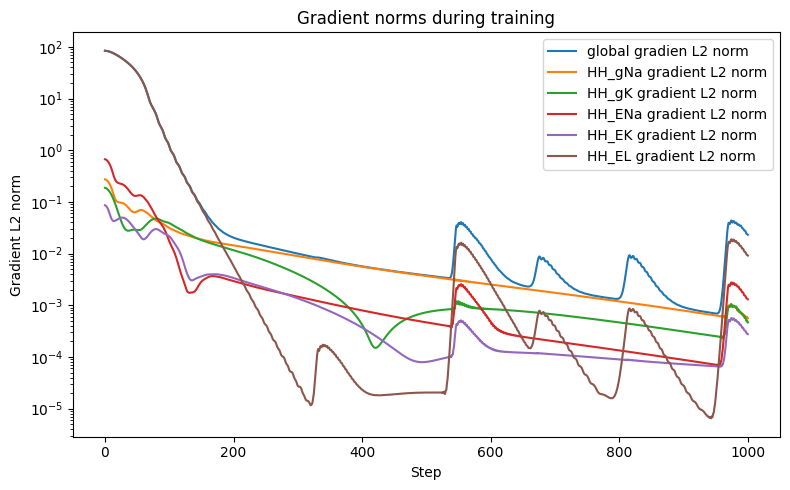

In [17]:
steps = range(len(grad_hist_global))
plt.figure(figsize=(8,5))

# global
plt.plot(steps, ema(grad_hist_global, 0.9), label="global gradien L2 norm")

# per-parameter
for k, series in grad_hist_perkey.items():
    plt.plot(steps, ema(series, 0.9), label=f"{k} gradient L2 norm")

plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Gradient L2 norm")
plt.title("Gradient norms during training")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


In [ ]:
def integrate_hh_states(state0, currents, params, dt):
    """
    Returns arrays of shape (T,) for V, m, h, n.
    """
    def step(carry, cur):
        new_state, _ = hh_step(carry, cur, params, dt)
        return new_state, new_state  # emit full state each step
    final_state, stacked = jax.lax.scan(step, state0, currents)
    V_trace, m_trace, h_trace, n_trace = stacked
    return final_state, V_trace, m_trace, h_trace, n_trace


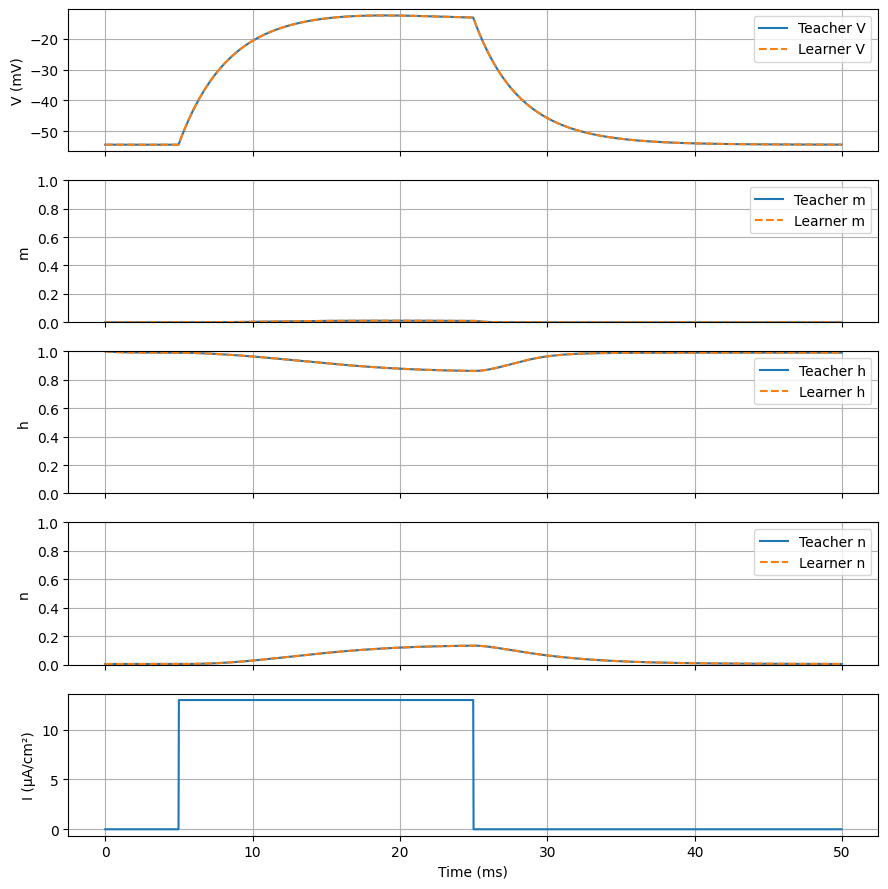

In [ ]:
b_idx = 0          # which example from the batch to plot
c_idx = 0          # which cell within that example to plot
amp = float(sample_inputs[b_idx, c_idx])
curr_1cell = amp * MASK                       # shape (T,)
t_axis = jnp.arange(curr_1cell.shape[0]) * dt

learner_phys_cell = {k: v[c_idx] for k, v in final_phys.items()}
teacher_phys_cell = {k: v[c_idx] for k, v in teacher_params_physical.items()}

def make_state0(phys):
    V0 = phys["HH_EL"]
    m0 = x_inf(alpha_m, beta_m, V0)
    h0 = x_inf(alpha_h, beta_h, V0)
    n0 = x_inf(alpha_n, beta_n, V0)
    return (V0, m0, h0, n0)

state0_learner = make_state0(learner_phys_cell)
state0_teacher = make_state0(teacher_phys_cell)

_, V_L, m_L, h_L, n_L = integrate_hh_states(state0_learner, curr_1cell, learner_phys_cell, dt)
_, V_T, m_T, h_T, n_T = integrate_hh_states(state0_teacher, curr_1cell, teacher_phys_cell, dt)

fig, axs = plt.subplots(5, 1, figsize=(9, 9), sharex=True)

# V
axs[0].plot(t_axis, V_T, label="Teacher V")
axs[0].plot(t_axis, V_L, '--', label="Learner V")
axs[0].set_ylabel("V (mV)"); axs[0].legend(); axs[0].grid(True)

# m
axs[1].plot(t_axis, m_T, label="Teacher m")
axs[1].plot(t_axis, m_L, '--', label="Learner m")
axs[1].set_ylabel("m"); axs[1].set_ylim(0, 1); axs[1].grid(True); axs[1].legend(loc="upper right")

# h
axs[2].plot(t_axis, h_T, label="Teacher h")
axs[2].plot(t_axis, h_L, '--', label="Learner h")
axs[2].set_ylabel("h"); axs[2].set_ylim(0, 1); axs[2].grid(True); axs[2].legend(loc="upper right")

# n
axs[3].plot(t_axis, n_T, label="Teacher n")
axs[3].plot(t_axis, n_L, '--', label="Learner n")
axs[3].set_ylabel("n"); axs[3].set_ylim(0, 1); axs[3].grid(True); axs[3].legend(loc="upper right")

# I
axs[4].plot(t_axis, curr_1cell)
axs[4].set_ylabel("I (µA/cm²)"); axs[4].set_xlabel("Time (ms)"); axs[4].grid(True)

plt.tight_layout(); plt.show()


In [ ]:
def integrate_hh_states(state0, currents, params, dt):
    def step(carry, cur):
        new_state, _ = hh_step(carry, cur, params, dt)
        return new_state, new_state
    _, stacked = jax.lax.scan(step, state0, currents)
    V, m, h, n = stacked
    return V, m, h, n

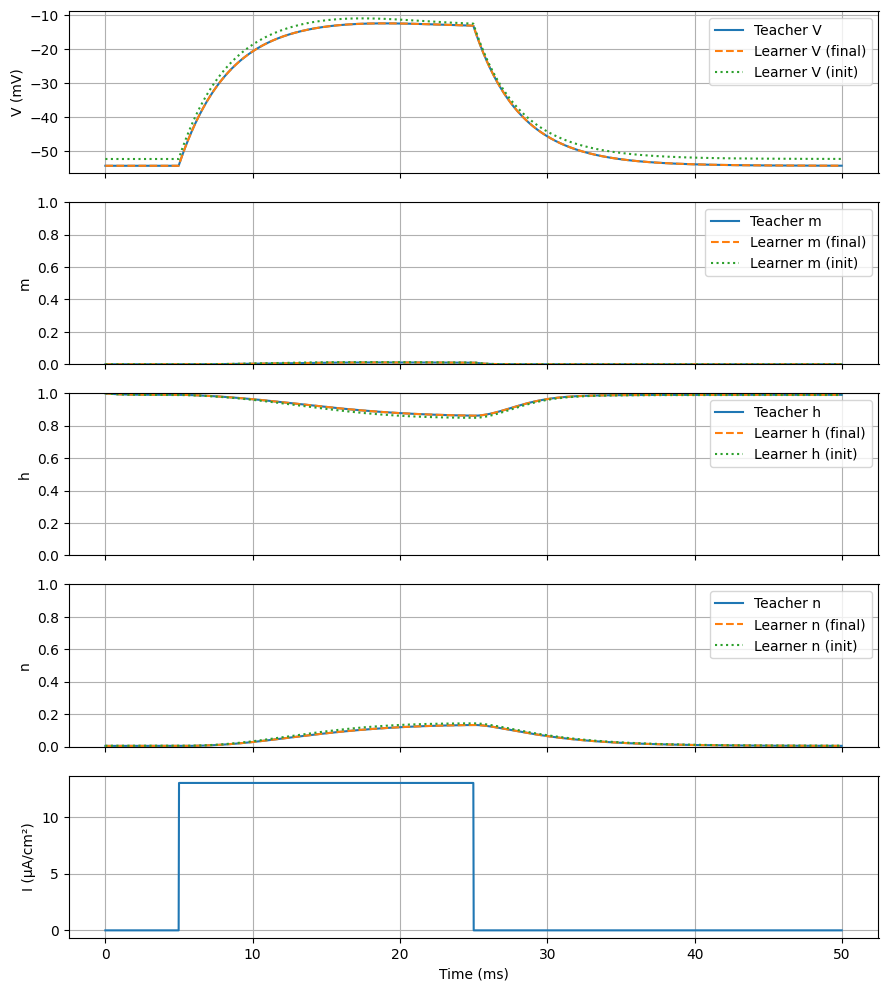

In [ ]:
b_idx, c_idx = 0, 0
amp = float(sample_inputs[b_idx, c_idx])
curr_1cell = amp * MASK
t_axis = jnp.arange(curr_1cell.shape[0]) * dt

init_phys = transform.forward(learn_opt_params)                 # learner at init
init_cell = {k: init_phys[k][c_idx] for k in init_phys}
state0_init = make_state0(init_cell)
V0, m0, h0, n0 = integrate_hh_states(state0_init, curr_1cell, init_cell, dt)

final_cell   = {k: final_phys[k][c_idx] for k in final_phys}
teacher_cell = {k: teacher_params_physical[k][c_idx] for k in teacher_params_physical}

state0_final   = make_state0(final_cell)
state0_teacher = make_state0(teacher_cell)

V_L, m_L, h_L, n_L = integrate_hh_states(state0_final,   curr_1cell, final_cell,   dt)
V_T, m_T, h_T, n_T = integrate_hh_states(state0_teacher, curr_1cell, teacher_cell, dt)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(9, 10), sharex=True)

axs[0].plot(t_axis, V_T, label="Teacher V")
axs[0].plot(t_axis, V_L, '--', label="Learner V (final)")
axs[0].plot(t_axis, V0, ':', label="Learner V (init)")
axs[0].set_ylabel("V (mV)"); axs[0].legend(); axs[0].grid(True)

for ax, T, L, Z, lab in [
    (axs[1], m_T, m_L, m0, "m"),
    (axs[2], h_T, h_L, h0, "h"),
    (axs[3], n_T, n_L, n0, "n"),
]:
    ax.plot(t_axis, T, label=f"Teacher {lab}")
    ax.plot(t_axis, L, '--', label=f"Learner {lab} (final)")
    ax.plot(t_axis, Z, ':', label=f"Learner {lab} (init)")
    ax.set_ylabel(lab); ax.set_ylim(0, 1); ax.grid(True); ax.legend(loc="upper right")

axs[4].plot(t_axis, curr_1cell, label="Injected I (shared)")
axs[4].set_ylabel("I (µA/cm²)"); axs[4].set_xlabel("Time (ms)"); axs[4].grid(True)

plt.tight_layout(); plt.show()
